# IMDb Review Analysis and Movie Recommendation

## 1. Intro

### 1.1 Data Set
In this project, we are working on the IMDb movie reviews which is collected from the IMDb website http://www.imdb.com/. 

The Internet Movie Database (IMDb) is an online database of information related to films, television programs and video games, including cast, production crew, fictional characters, biographies, plot summaries, trivia and reviews. It's launched in 1990 by computer programmer Col Needham. As of September 2016, IMDb has approximately 3.9 million titles (including episodes) and 7.4 million personalities in its database, as well as 67 million registered users. [*From Wikipedia*]


### 1.2 Data Preprocessing
In order to collect the all the information from the IMDb website. We make use of the [imdbpie](https://github.com/richardasaurus/imdb-pie) module. And we save the results into two tables in sqlite3. Due to the limitation of time, we only randomly crawl about 1% of all the movies in IMDb. Code for data collection can be found at [Data Collection Code]( https://github.com/JinyiLu/15688-Team/blob/master/doc/DataCollection.md). Data can be found at [Data]()

We store the data in two sqlite3 tables: **movie** and **review**.

**Movie** contains all the information about movies. Its schema is:

| Column Name  |  Type | Comment |
|---|---|---|
| imdb_id  | TEXT  | primary key  |
| title  | TEXT  | title of the movie  |
| type  | TEXT  | type of the movie  |
| year | INTEGER | movie release year |
| tagline | TEXT | |
| plots | TEXT | |
| plot_outline | TEXT | |
| rating | INTEGER | |
| genres | TEXT | |
| votes | INTEGER | number of user vote the movies |
| runtime | INTEGER | in seconds |
| poster_url | TEXT | |
| cover_url | TEXT | |
| release_date | TEXT | |
| certification | TEXT | |
| trailer_image_urls | TEXT | |
| directors_sumary | TEXT | |
| creators | TEXT | |
| cast_summary | TEXT | |
| writers_summary | TEXT | |
| credits | TEXT | |
| trailers | TEXT | ||


**Review** contains all the information about reviews. Its schema is:

| Column Name  |  Type | Comment |
|---|---|---|
|imdb_id | TEXT | |
|username | TEXT | |
|content | TEXT | |
|postdate| TEXT | |
|rating | INTEGER | user rating 1-10 |
|summary | TEXT | review summary |
|status | TEXT | |
|user_location|TEXT| |
|user_score| INTEGER | |
|user_score_count | INTEGER | ||

Following are some samples:

In [1]:
# import necessary libraries
import util
import numpy as np
import sqlite3
import pandas as pd
import ast

import scipy.sparse as sp
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.ensemble import ExtraTreesClassifier

from IPython.display import Image
from IPython.display import display

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

matplotlib.rc("figure", figsize=(8,6))
matplotlib.rc("axes", labelsize=16, titlesize=16)
matplotlib.rc("xtick", labelsize=14)
matplotlib.rc("ytick", labelsize=14)
matplotlib.rc("legend", fontsize=14)
matplotlib.rc("font", size=14)

In [2]:
DB_NAME = 'imdb_data/imdb_final.db'
conn = sqlite3.connect(DB_NAME)

df = pd.read_sql_query("SELECT * FROM movie", conn)
df.head()

,imdb_id,title,type,year,tagline,plots,plot_outline,rating,genres,votes,...,cover_url,release_date,certification,trailer_image_urls,directors_summary,creators,cast_summary,writers_summary,credits,trailers
0,tt1756420,Bez vini vinovatiye,feature,2008,None,[],None,5.1,[u'Drama'],18,...,None,None,None,[],[<Person: u'Gleb Panfilov' (u'nm0659368')>],[],"[<Person: u'Inna Churikova' (u'nm0161500')>, <...",[],"[<Person: u'Gleb Panfilov' (u'nm0659368')>, <P...",[]
1,tt0241250,The Blind Date,feature,2000,None,"[u""Lucy Kennedy, a one time police detective w...","Lucy Kennedy, a one time police detective whos...",6.2,[u'Thriller'],39,...,None,None,15,[],[<Person: u'Nigel Douglas' (u'nm0235196')>],[],"[<Person: u'Zara Turner' (u'nm0877947')>, <Per...","[<Person: u'Simon Booker' (u'nm0095405')>, <Pe...","[<Person: u'Nigel Douglas' (u'nm0235196')>, <P...",[]
2,tt0106806,Emmanuelle's Love,feature,1993,The Legend is back and the adventure begins!,"[u""Emmanuelle withdraws into a temple in Tibet...","Emmanuelle withdraws into a temple in Tibet, w...",4.6,"[u'Drama', u'Romance']",152,...,https://images-na.ssl-images-amazon.com/images...,1993-04-04,18,[],[<Person: u'Francis Leroi' (u'nm0163095')>],[],[<Person: u'Marcela Walerstein' (u'nm0907380')...,"[<Person: u'Emmanuelle Arsan' (u'nm0037491')>,...","[<Person: u'Francis Leroi' (u'nm0163095')>, <P...",[]
3,tt2635824,We Ride: The Story of Snowboarding,documentary,2013,The story of snowboarding told by the people w...,"[u""Grain Media and Burn Energy Drink tell the ...",Grain Media and Burn Energy Drink tell the sto...,7.8,"[u'Documentary', u'Adventure', u'History', u'S...",81,...,https://images-na.ssl-images-amazon.com/images...,2013-01-31,None,[],"[<Person: u'Jon Drever' (u'nm2270358')>, <Pers...",[],"[<Person: u'Danny Davis' (u'nm2289497')>, <Per...",[<Person: u'Jon Drever' (u'nm2270358')>],"[<Person: u'Jon Drever' (u'nm2270358')>, <Pers...",[]
4,tt0426589,Succubus,feature,1987,Sex Slaves To The Devil!,[u'The Von Romburg castle has been cursed ever...,The Von Romburg castle has been cursed ever si...,6.6,[u'Horror'],7,...,None,1987,None,[],[<Person: u'Patrick Dromgoole' (u'nm0238245')>],[],"[<Person: u'Barry Foster' (u'nm0287687')>, <Pe...","[<Person: u'Bob Baker' (u'nm0048276')>, <Perso...",[<Person: u'Patrick Dromgoole' (u'nm0238245')>...,[]


In [3]:
df = pd.read_sql_query("SELECT * FROM review", conn)
df.head()

,imdb_id,username,content,postdate,rating,summary,status,user_location,user_score,user_score_count
0,tt2635824,(borkoboardo),It's a difficult one - the history of snowboar...,2013-02-26,4.0,Fans will love it!,G,Livigno,6.0,9.0
1,tt2635824,surfs_up1976,Another attempt of capturing the history of sn...,2013-02-25,3.0,"Oh boy, what a mess...",S,Sweden,3.0,4.0
2,tt0079677,lazarillo,This is one of those films that kind of fall i...,2008-11-24,NaN,Not good but interesting--and certainly offbea...,G,"Denver, Colorado and Santiago, Chile",5.0,7.0
3,tt0079677,Wizard-8,"Today, the all-but-forgotten movie ""(Friday Th...",2012-07-23,NaN,"Great effort is obvious, but it doesn't work i...",G,"Victoria, BC",2.0,3.0
4,tt0079677,HumanoidOfFlesh,After tragic death of his parents-the woman ac...,2010-12-12,8.0,Young boy's tormented psyche.,G,"Chyby, Poland",4.0,7.0


## 2. Data Set Analysis

### 2.1 Statistics of The User Reviews
Firstly load the rating file. The rating file contains the user/movie rating matrix. Each row of the matrix represents a particular user and each column of the matrix represents a particular movie. The rating range is from 1.0 to 10.0.

In [4]:
# load the rating matrix
M = util.load_sparse_csr("imdb_data/rating.npz").toarray()

In [5]:
# user count in the rating matrix
user_cnt = M.shape[0]
print "user count in the rating matrix : %s" % user_cnt 
# movie count in the rating matrix
movie_cnt = M.shape[1]
print "movie count in the rating matrix : %s " % movie_cnt

user count in the rating matrix : 18060
movie count in the rating matrix : 1603 


Next we compute the **sparsity** of the rating matrix.

In [6]:
# compute the sparsity 
sparsity = len(M.nonzero()[0]) * 1.0
sparsity /= (M.shape[0] * M.shape[1])
sparsity *= 100
print 'Sparsity for the rating matrix : {:4.2f}%'.format(sparsity)

Sparsity for the rating matrix : 0.09%


Compared to the MovieLens dataset(which is a classic dataset for training recommendation systems, the MovieLens dataset is available in the GroupLens website.), our rating matrix has a relatively higher sparsity. The sparsity of movieLens is 6.3% which is more reasonable than ours. We encounter some problems due to the high sparsity of the dataset when we are building the recommendation systems. We will talk about this later.  

Since a user who writes a review will possibly not rate the movie, we want to check the ratio of rating count to review count.

In [7]:
# read review table to pandas
df_review = pd.read_sql_query("SELECT * FROM review", conn)
df_movie = pd.read_sql_query("SELECT * FROM movie", conn)

In [8]:
def compute_ratio_review_to_rating(df_review):
    review_cnt = df_review.shape[0]
    rating_nan_cnt = df_review['rating'].isnull().sum()
    print "Ratio of rating cnt to review cnt : {:4.2f}% ".format((review_cnt-rating_nan_cnt) * 1.0 / review_cnt * 100)
compute_ratio_review_to_rating(df_review)

Ratio of rating cnt to review cnt : 82.87% 


Next we check the distribution of ratings and the mean and standard deviation of ratings.

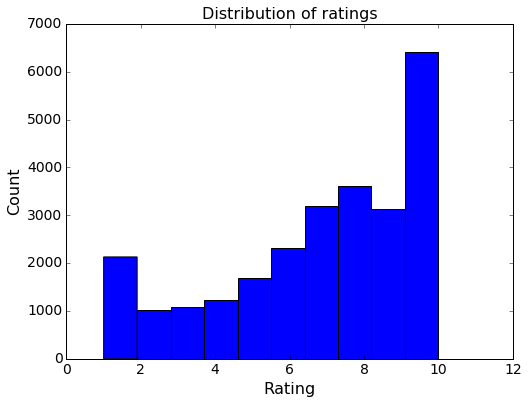

In [9]:
# Distribution of ratings
# remove nan rating
df_remove_nan_rating = df_review[df_review['rating'].isnull() == False]
plt.hist(df_remove_nan_rating['rating'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title('Distribution of ratings')

In [10]:
# mean and standard deviation of ratings
print np.mean(df_remove_nan_rating['rating'])
print np.std(df_remove_nan_rating['rating'])

6.90655725014
2.87299501904


On a scale range from 1.0 to 10.0, the average rating is 6.90. The standard deviation is 2.87.
We can plot the distribution of mean ratings for movies.

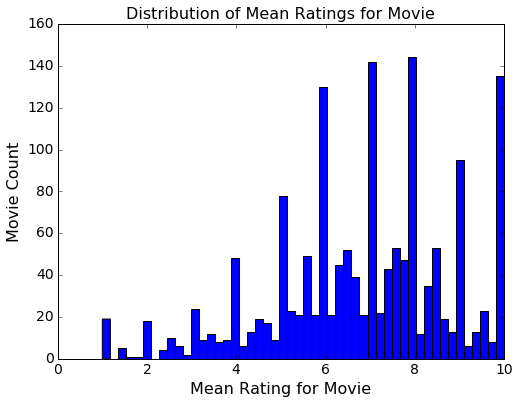

In [11]:
mean_rating = pd.DataFrame(M).replace('0', np.nan).mean(axis=0)
plt.hist(mean_rating, bins=50)
plt.xlabel("Mean Rating for Movie")
plt.ylabel("Movie Count")
plt.title('Distribution of Mean Ratings for Movie')

we can also plot the distribution of number of ratings per user.

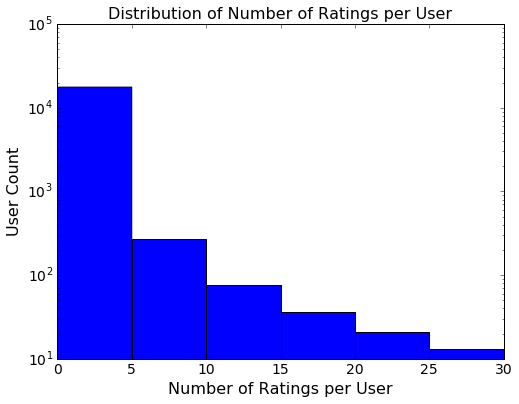

In [12]:
num_of_rating = pd.DataFrame(M).replace('0', np.nan).count(axis=1)
plt.hist(num_of_rating, bins=[0, 5, 10, 15, 20, 25, 30])
plt.xlabel("Number of Ratings per User")
plt.ylabel("User Count")
plt.yscale('log')
plt.title('Distribution of Number of Ratings per User')

From the diagram, we can see that most of the user has less than 5 ratings. This caused our rating matrix very sparse.

### 2.2 Top Movies and Users

We can check the top 10 movie with the highest review count. 

Title : Pulp Fiction
Review Count : 2227


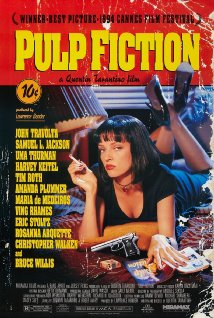

Title : Taxi Driver
Review Count : 886


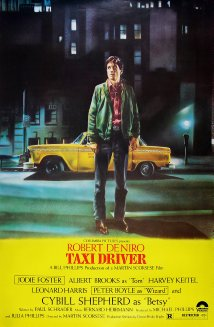

Title : Léon: The Professional
Review Count : 849


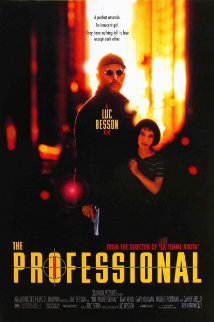

Title : Walk the Line
Review Count : 815


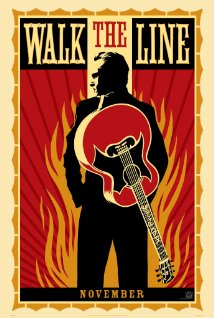

Title : The Haunting
Review Count : 806


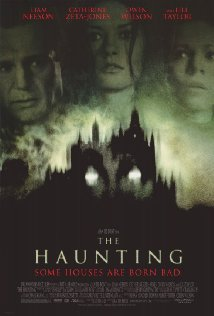

Title : I, Robot
Review Count : 789


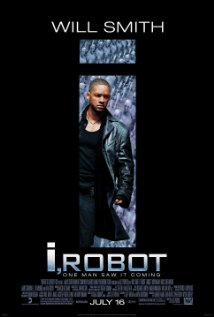

Title : Click
Review Count : 686


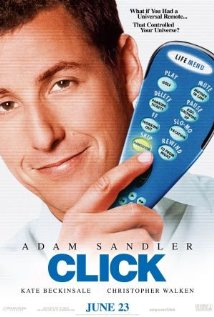

Title : A Knight's Tale
Review Count : 659


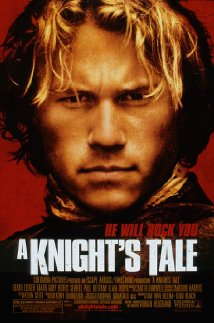

Title : Dogville
Review Count : 609


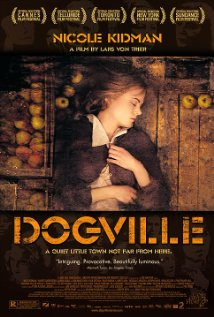

Title : Dungeons & Dragons
Review Count : 589


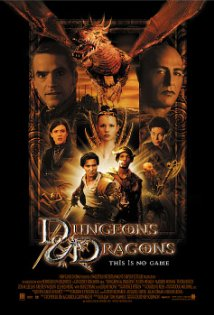

In [13]:
def display_top_k_most_reviewed_movie(k):
    idx = 0
    # some of the movies do not have a poster, we just ignore these kinds of movies
    total_cnt = 0
    reviews = df_review['imdb_id'].value_counts()
    movies = reviews.index
    
    while total_cnt < k:
        row = df_movie[df_movie['imdb_id'] == movies[idx]]
        if row['cover_url'].iloc[0]:
            title = row['title'].iloc[0]
            if title:
                print "Title : " + title
            print "Review Count : " + str(reviews[movies[idx]])
            display(Image(row['cover_url'].iloc[0]))
            total_cnt += 1
        idx += 1
    return
display_top_k_most_reviewed_movie(10)

We can also check the top 10 movie with the highest average ratings. 

/Users/jinyi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Title : P.A.T.R.I.O.T
Runtime : nan


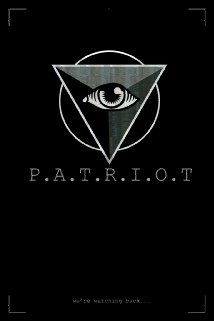

Title : Heartbeat
Runtime : 240.0


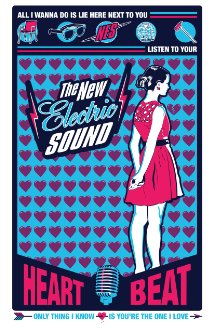

Title : Light Study
Runtime : 840.0


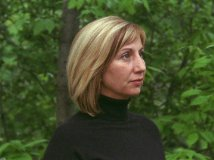

Title : Totem
Runtime : 360.0


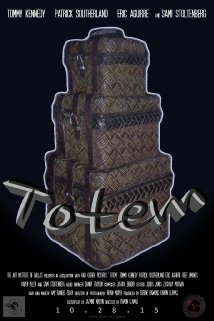

Title : Savor
Runtime : 60.0


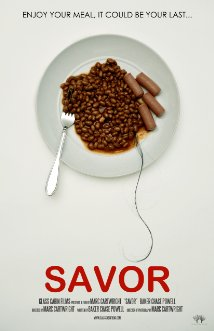

Title : Lost: 10th Anniversary Reunion - Cast and Creators Live at PaleyFest
Runtime : 4080.0


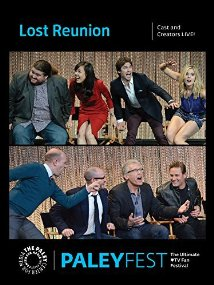

Title : Induction
Runtime : 1020.0


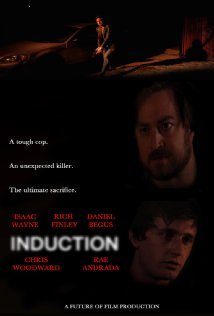

Title : Sveriges Bästa Svensk
Runtime : 1920.0


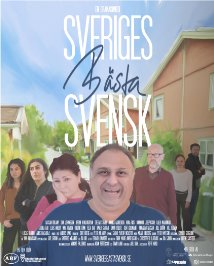

Title : Operation A.N.G.E.L
Runtime : 1500.0


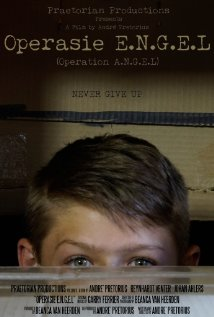

Title : K&P
Runtime : 720.0


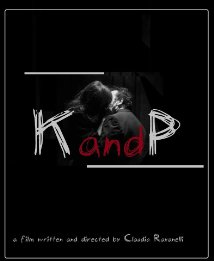

In [14]:
def display_top_k_movie_with_highest_rating(k):
    idx = 0
    # some of the movies do not have a poster, we just ignore these kinds of movies
    total_cnt = 0
    # sort the dataframe by rating descending
    sorted_movie = df_movie.sort('rating', ascending=False)['imdb_id'].values
    
    while total_cnt < k:
        cover_url = df_movie[df_movie['imdb_id'] == sorted_movie[idx]]['cover_url'].iloc[0]
        if cover_url:
            title = df_movie[df_movie['imdb_id'] == sorted_movie[idx]]['title'].iloc[0]
            if title:
                print "Title : " + title
            runtime = df_movie[df_movie['imdb_id'] == sorted_movie[idx]]['runtime'].iloc[0]
            if runtime:
                print "Runtime : " + str(runtime)
            display(Image(cover_url))
            total_cnt += 1
        idx += 1
    return
display_top_k_movie_with_highest_rating(10)

We can also check the top 10 active users who has the most number of reviews.

In [15]:
def display_top_k_most_active_users(k):
    total_cnt = 0
    reviews = df_review['username'].value_counts()
    users = reviews.index
    
    while total_cnt < k:
        print users[total_cnt]
        total_cnt += 1
        
    return
display_top_k_most_active_users(10)

planktonrules
Michael_Elliott
bkoganbing
anonymous
SnoopyStyle
TheLittleSongbird
Leofwine_draca
Claudio Carvalho
bob the moo
gavin6942


### 2.3 User Location

Users in IMDb comes from various kinds of countries. It is very interesting to do some analysis to see if there are any location bias in terms of movie preference.



In [16]:
user = pd.read_sql_query("SELECT * FROM review", conn)

In [17]:
# group different location into usa
usa = ['United States', 'USA', 'Alabama', 'AL', 'Alaska', 'AK', 'Arizona', 'AZ', 'Arkansas',\
      'AR', 'California', 'CA', 'Colorado', 'CO', 'Connecticut', 'CT', 'Delaware', 'DE', \
      'Florida', 'FL', 'Georgia', 'GA', 'Hawaii', 'HI', 'Idaho', 'ID', 'Illinois', 'IL', \
      'Indiana', 'IN', 'Iowa', 'IA', 'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', \
      'Maine', 'ME', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', 'Minnesota', \
      'MN', 'Mississippi', 'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', \
      'Nevada', 'NV', 'New Hampshire', 'NH', 'New Jersey', 'NJ', 'New Mexico', 'NM', 'New York', \
      'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Ohio', 'OH', 'Oklahoma', 'OK', \
      'Oregon', 'OR', 'Pennsylvania', 'PA', 'Rhode Island', 'RI', 'South Carolina', 'SC', \
      'South Dakota', 'SD', 'Tennessee', 'TN', 'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT',\
      'Virginia', 'VA', 'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', \
      'Wyoming', 'WY', 'US', 'Los Angeles', 'Chicago']

reg = []
for u in usa:
    reg.append('.*'+u+'.*')

user['user_location'] = user['user_location'].replace(to_replace=reg, value='United States', regex=True)

mask = ['UK', '.*London.*', 'England', '.*United Kingdom.*']
user['user_location'] = user['user_location'].replace(to_replace=mask, value='United Kingdom', regex=True)

mask = ['.*Australia.*']
user['user_location'] = user['user_location'].replace(to_replace=mask, value='Australia', regex=True)

mask = ['.*Canada.*']
user['user_location'] = user['user_location'].replace(to_replace=mask, value='Canada', regex=True)

Firstly, we try to analysis the user location distribution in our dataset. So we plot the distribution of number of users in each country in the log scale.

(21637, 10)


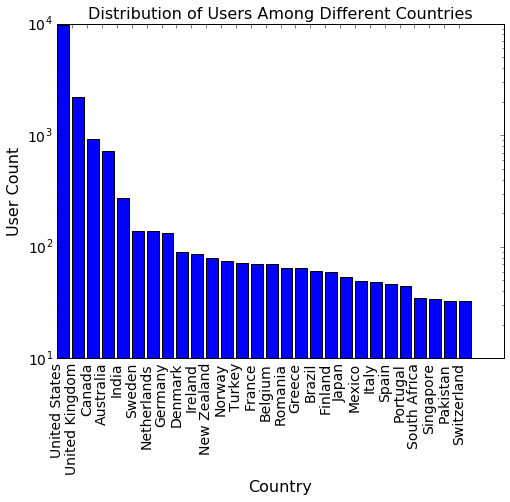

In [18]:
# drop duplicate users
user_nodup = user.drop_duplicates('username')
print user_nodup.shape

loc_freq = user_nodup['user_location'].value_counts()
loc_freq = loc_freq[loc_freq>30]

# plt.plot(range(len(loc_freq)), loc_freq.values)
plt.bar(range(len(loc_freq)), loc_freq.values)
plt.yscale('log')
plt.xticks(range(len(loc_freq)), loc_freq.index, rotation='vertical')

plt.xlabel("Country")
plt.ylabel("User Count")
plt.title('Distribution of Users Among Different Countries')

plt.show()

As we can see from the figure, most of the users in IMDb are coming from United States, United Kingdom, Canada and Australia. How about the average rating for each country?

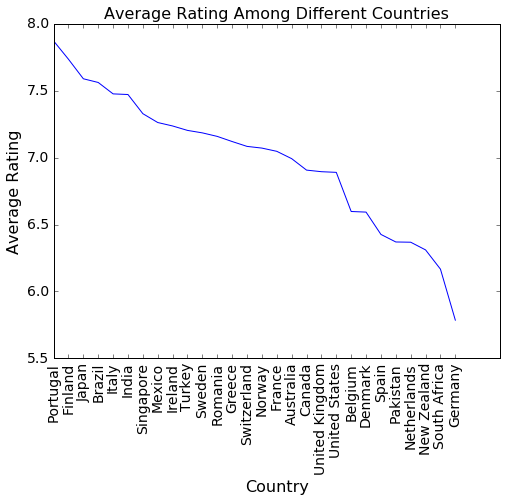

In [19]:
user_rating = user.dropna(axis=0, subset=['rating'])
# only consider top countries
user_rating = user_rating[user_rating['user_location'].isin(loc_freq.index)]
loc_rating = user_rating.groupby('user_location')['rating'].mean()
loc_rating = loc_rating.sort_values(ascending=False)

plt.plot(range(len(loc_rating)), loc_rating.values)
plt.xticks(range(len(loc_rating)), loc_rating.index, rotation='vertical')

plt.xlabel("Country")
plt.ylabel("Average Rating")
plt.title('Average Rating Among Different Countries')

plt.show()

It's very interesting users in some popular countries tend to give a low rating compare with other countries. For example, the numbers of users in Germany and Sweden are almost the same. But in generally German tend to give a lower rate to the movies than Swedish so they are more critical when watching movies.

### 2.4 Movie Release Date
Besides the geospatial dimensionality, it's also interesting to analysis something related to time. Is the number of relased movies is keep growing?

In [20]:
movie = pd.read_sql_query("SELECT * FROM movie", conn)

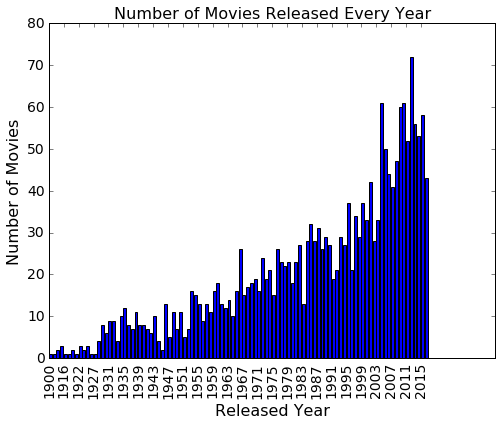

In [21]:
# only consider feature type movie
movie_onlyfeature = movie[movie['type'] == 'feature']
year_freq = movie_onlyfeature['year'].value_counts()
year_freq = year_freq.sort_index()

plt.bar(range(len(year_freq)), year_freq.values)

labels = []
idx = []
for i in range(0, len(year_freq), 4):
    idx.append(i)
    labels.append(year_freq.index[i])

plt.xticks(idx, labels, rotation='vertical')

plt.xlabel("Released Year")
plt.ylabel("Number of Movies")
plt.title('Number of Movies Released Every Year')

plt.show()

Although IMDb was launched in 1990, it still contains many information about old movies. It's very clear that general trend of the number of movies that are released in each year are increasing. And recently, the velocity of increase is very fast.

How about the length of the movie?

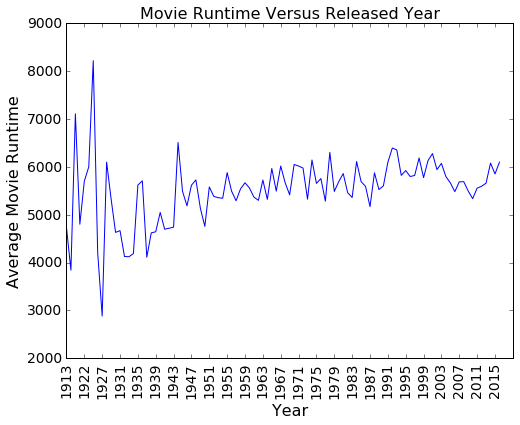

In [22]:
movie_runtime = movie_onlyfeature.dropna(axis=0, subset=['runtime', 'year'])

year_runtime = movie_runtime.groupby('year')['runtime'].mean()
year_runtime = year_runtime.sort_index()

plt.plot(range(len(year_runtime)), year_runtime.values)

labels = []
idx = []
for i in range(0, len(year_runtime), 4):
    idx.append(i)
    labels.append(year_runtime.index[i])
    
plt.xticks(idx, labels, rotation='vertical')

plt.xlabel("Year")
plt.ylabel("Average Movie Runtime")
plt.title('Movie Runtime Versus Released Year')

plt.show()

The result shows that although we generally tend to produce more movies. The length of the movie doesn't change a lot.

### 2.5 Genre Information


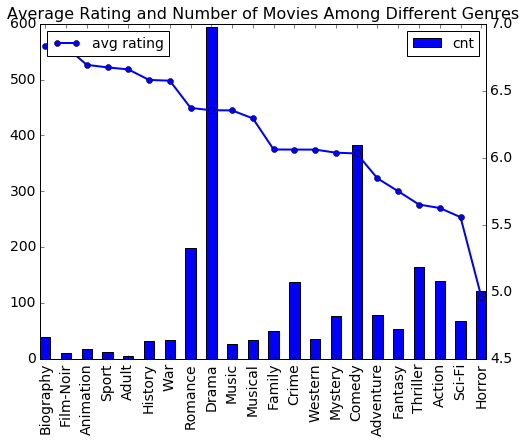

In [23]:
# only consider the movies with large number of votes
movie_rating = movie_onlyfeature[movie_onlyfeature['votes'] > 30]

genres = {}
for row in movie_rating.iterrows():
    gs = ast.literal_eval(row[1]['genres'])
    if gs is None:
        continue
    for g in gs:
        if g in genres:
            genres[g]['cnt'] += 1
            genres[g]['rating'] += row[1]['rating']
        else:
            genres[g] = {'cnt':1, 'rating':row[1]['rating'], 'label':g}

g_labels = []
g_cnt = []
g_avgrating = []

for g in genres:
    g_labels.append(g)
    g_cnt.append(genres[g]['cnt'])
    g_avgrating.append(genres[g]['rating']/float(genres[g]['cnt']))

g_df = pd.DataFrame({'label':g_labels, 'cnt':g_cnt, 'rating':g_avgrating})
g_df = g_df.sort_values('rating', ascending=False)


ax = g_df[['label', 'cnt']].plot(kind='bar', label='cnt')
plt.xticks(range(len(g_df)), g_df['label'], rotation='vertical')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), g_df[['rating']].values, linestyle='-', marker='o', linewidth=2.0, label='avg rating')
ax2.legend(loc=2)

plt.xlabel("Genre")
plt.title('Average Rating and Number of Movies Among Different Genres')

plt.show()

## 3. Recommendation System

In this section, we want to explore several methods to build a recommendation system for IMDb users with all the data we have by predicting the movie ratings of users.

### 3.1 Data Preparation
In order to evaluate our recommender systems, we need to firstly split the whole dataset to train dataset and test dataset. Before doing that, we apply a filter to remove users who have rated less than 5 movies and movies which do not have more than 5 reviews. In this way we reduce the sparsity of the rating matrix from 0.09% to 2.57%.

In [24]:
# load the rating matrix
M = util.load_sparse_csr("imdb_data/rating.npz").toarray()
movie_names = np.load("imdb_data/movies.npy")
user_names = np.load("imdb_data/users.npy")

In [25]:
new_rating_m, new_user_names, new_movie_names = util.rating_filter(M, user_names, movie_names, (5,5))

(18060,) (1603,)
Original #rating 25658
Remaining #user 358 #movie 504
(358, 504)
Remaining #rating 4629
Sparsity for the rating matrix : 2.57%


Then we split the whole dataset into three disjoint datasets : train dataset, valid dataset and test dataset.

In [26]:
# split dataset to train, valid and test
train, valid, test, user_mask = util.split_dataset(new_rating_m)
print train.shape, np.sum(train>0)
print valid.shape, np.sum(valid>0)
print test.shape, np.sum(test>0)

Number of user delete 5
(353, 504) 2669
(353, 504) 1040
(353, 504) 911


There are two most popular methods to build a recommender system : **Collaborative Filtering (CF)** and **Content-Based**. 

### 3.2 Collaborative Filtering (CF)
Furthermore, Collaborative Filtering can be divided into **Memory-Based** and **Model-Based**. We will try both methods in the following sections.

#### 3.2.1 Memory-Based Collaborative Filtering
We will use cosine similarity to measure the similarity between users and make predictions for users based on the similarity matrix. Firstly, we build the similarity matrix. A cell [i,j] in this matrix represents the similarity between user i and user j.

In [27]:
def build_similarity_matrix(rating):
    """ 
    Input:
        rating (sp.csr_matrix) : each row represents users' preferences
    Output:
        similarity (matrix) : cosine similarity matrix
    """
    # compute norm for each row
    norm = np.linalg.norm(rating, axis=1)
    # normalize each row
    rating = rating / norm[:,None]
    #print np.isnan(np.min(rating_a))
    similarity = rating.dot(rating.T)
    return similarity

In [28]:
sim_train = build_similarity_matrix(train)

In [29]:
sim_train

array([[ 1.        ,  0.43735829,  0.08950241, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.43735829,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08950241,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

Now with our similarity matrix, we can predict ratings.

In [30]:
# predict ratings
def predict(rating, similarity):
    """ 
    Input:
        rating (sp.csr_matrix) : each row represents users' preferences
        similarity (matrix) : cosine similarity matrix
    Output:
        prediction (sp.csr_matrix) : prediction of users' ratings
    """
    # compute weighted sum
    weighted_sum = similarity.dot(rating)
    # normalize by sum of weights
    return weighted_sum / np.array([np.abs(similarity).sum(axis=1)]).T

In [31]:
prediction_train = predict(train,sim_train)

In [32]:
prediction_train

array([[ 0.04754326,  0.00885587,  0.        , ...,  0.19947584,
         0.27240836,  0.63124905],
       [ 0.03157623,  0.00406416,  0.01209301, ...,  0.23347786,
         0.21788713,  1.24581063],
       [ 1.36302382,  0.        ,  0.01772305, ...,  0.23720634,
         0.20087877,  0.80829312],
       ..., 
       [ 0.05394038,  0.09635109,  0.25092393, ...,  0.79631739,
         0.73736575,  0.0684398 ],
       [ 0.        ,  0.57146874,  0.        , ...,  0.35231747,
         0.        ,  0.66956285],
       [ 0.        ,  0.        ,  0.21237756, ...,  0.67816357,
         0.15169825,  0.25844282]])

We then compare the predictions with validation set to validate the quality of our recommender model. We use mean squared error(MSE) as our metric.

In [33]:
# compute validation metric
def compute_mse(prediction, real):
    """ 
    Input:
        prediction (matrix) : prediction of users' ratings
        real (matrix) : real user ratings
    Output:
        mse (double) : mean squared error
    """
    # rule out the empty rating
    return np.mean(((real - prediction)**2)[real.nonzero()])

In [34]:
print 'MSE at train %f valid %f' % (compute_mse(prediction_train, train), compute_mse(prediction_train, valid))

MSE at train 26.831747 valid 47.832731


We have several thoughts about the result. Firstly, for the MovieLens dataset(which is a classic dataset for training recommendation systems) we mentioned in the Data Set Analysis section, after applying the same methods, the MSE is around 8. Since MovieLens dataset has a rating in the range from 0 to 5 and our dataset has a rating in the range from 0 to 10, we scale 8 to 8 * 4 = 32. Our MSE is much higher compared to 32. The main reason for the high error is the high sparsity of our rating matrix. From this, we can see one drawback of the memory-based collaborative filtering: When some new users are added to the system, the recommender systems have a bad performance recommending movies to such new users. Secondly, MSEs on train dataset and valid dataset have a big gap. The gab might be due to overfitting. Thirdly, after further observing the prediction matrix, we can see that many prediction cells have a value in the range from 0 to 1 compared to the original rating value 0 which indicates that the user have never rated the movie. What if we change the ratings of 0 to the mean raing for a specific user? The value 0 in our original rating matrix indicates a missing rating instead of a 0 rating actually. Thus we decide to try different ways to replace the original 0 values in the rating matrix.

A problem often involved in collaborative filtering for rating predicton is missing values, which occures when a movie is not rated by a user. There are various ways to deal with this problem. In this project, we explore three approaches:
1. replacing zeros with 5.5, which is the mean value of the range [1,10]
2. replacing zeros with the average (non-zero) rating value
3. replacing zeros with the average (non-zero) rating value of each row

To evaluate the performance, we build three training sets using the approaches described above. The test set remains unchanged.

In [35]:
# method 1: replace zeros with 5.5
train_m1 = np.array(train)
train_m1[train_m1==0] = 5.5

In [36]:
# method 2: replace zeros with the average (non-zero) rating value
train_m2 = np.array(train)
mean_train = np.mean(train_m2[train_m2.nonzero()])
train_m2[train_m2==0] = mean_train

In [37]:
# method 3: replace zeros with the average (non-zero) rating value of each row
train_m3 = np.array(train)
for row in train_m3:
    mean = np.mean(row[row.nonzero()])
    row[row==0] = mean

In [38]:
def evaluate(rating, test):
    similarity = build_similarity_matrix(rating)
    prediction = predict(rating, similarity)
    ret = compute_mse(prediction, test)
    #print 'MSE : ' + str(ret)
    return ret

In [39]:
for train in [train_m1, train_m2, train_m3]:
    print 'MSE at train %f valid %f' % (evaluate(train, train), evaluate(train, valid))

MSE at train 0.083050 valid 6.105118
MSE at train 0.069870 valid 4.590386
MSE at train 1.864077 valid 4.543764


We can see that after applying the above replacing methods, the MSE is greatly reduced. Thus we can draw a conclusion that the lower the sparsity of the rating matrix is, the lower the MSE will be. Also we can see that method 2 and method 3 lead to better performance than method 1. Intuitively it makes much more sense to use specific user's average rating to replace 0 rating of that user.

#### 3.2.2 Model-Based Collaborative Filtering

Model-Based Collaborative Filtering is based on **Matrix Factorization**. In matrix factorization, an important hyperparameter is the number of component (a.k.a number of latent factors). We experiment with different values for the number of components to study its effect on the performance.

We wrote a helper function **cf_mf** to do matrix factorization based on the training set and then compute the MSE based on the test set.

In [40]:
def cf_mf(train, test, n_components=10):
    """ 
    Input:
        train (matrix) : rating matrix for training (might be pre-processed)
        test (matrix): rating matrix for test
    Output:
        MSE : mean squared error
    """

    model = NMF(n_components) 
    model.fit(train)
    user_feature_matrix = model.transform(train)
    movie_feature_matrix = model.components_.T
    prediction = user_feature_matrix.dot(movie_feature_matrix.T)
    return compute_mse(prediction, test)

In [41]:
train_sets = [train_m1, train_m2, train_m3]
n_components_vals = range(1,100)

In [42]:
res = []
for train in train_sets:
    MSEs = []
    for n_components in n_components_vals:
        MSEs.append(cf_mf(train, valid, n_components))
    res.append(MSEs)

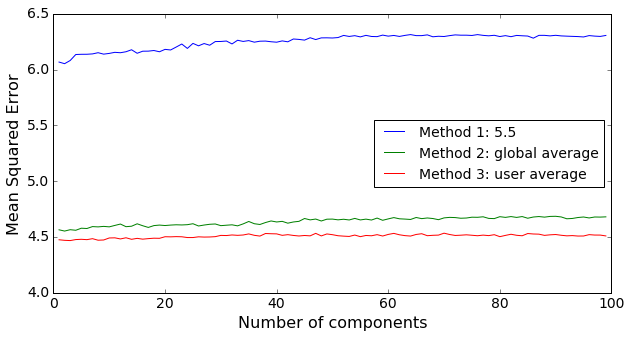

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
x = range(1,100)
plt.figure(figsize=(10,5))
plt.plot(x,res[0], label='Method 1: 5.5')
plt.plot(x,res[1], label='Method 2: global average')
plt.plot(x,res[2], label='Method 3: user average')
plt.ylim([4.0,6.5])
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')

We can see that method 3 (using user average to replace missing values) lead to the best performance. We can plot the curves individually to better visualize the effect of the number of components.

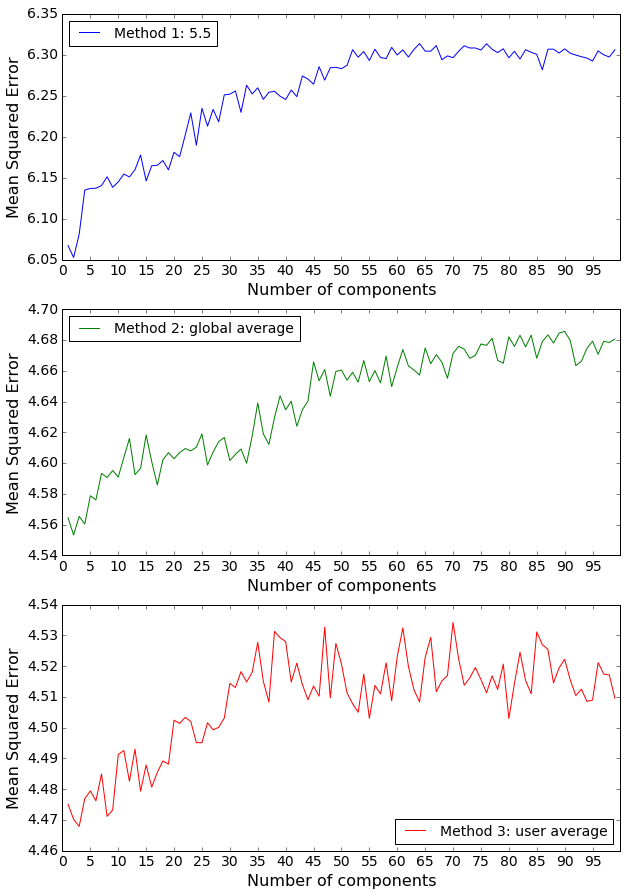

In [44]:
x = range(1,100)
plt.figure(figsize=(10,15))

plt.subplot(3, 1, 1)
plt.plot(x, res[0], label='Method 1: 5.5')
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.xticks(range(0,100, 5))
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(x, res[1], 'g', label='Method 2: global average')
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.xticks(range(0,100, 5))
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(x, res[2], 'r', label='Method 3: user average')
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.xticks(range(0,100, 5))
plt.legend(loc='best')

We can see that the MSE tends to increase as the number of components increases, but there are minor fluctuations. The best setting is around 3 to 8 components. For method 3, the best setting is at **4 components**. At first, we thought that the more number of latent features the better. However, with too many latent features the model might be overfitting.

### 3.3 Content-Based Filtering

Content-based filtering methods rely on the description of the item and a profile of the user's preference to make the recommendation. In a content-based recommender system, we firstly use the description of the item to create a vector representation of all the items. Then we need to build a user profile for every users which will indicate what kinds of items this user likes. So the main idea of content-based filtering is that users will like the items that are similar to those them liked in the past (based on their profile). So there are two main problem in order to use the content-based filtering.

* How to generate an abstract representation of items?
    * In our project, items are movies which contains various aspects, including plots, genres, credits, etc.
* How to build a user profile for every users?
    * Generally, a user profile can be built based on user's previous preference and/or user's history interaction with the system. However, in our project, we have no access to the user's interaction with IMDb. So we will only use their history preference.



#### 3.3.1 How to Learn the Content-Based Filtering Model

Let 
* $\theta^{(i)}$ be the profile representation of the i-th user (parameters of the model that we need to learn),
* $m^{(j)}$ be the vector representation of the j-th movie (created from other sources),
* $y^{(i,j)}$ be the rating for the j-th movie given by i-th user,
* $r^{(i,j)}$ be the mask for representing whether i-th user rates j-th motive. $r^{(i,j)} = 1$ means i-th user gives a rating to j-th movie. $r^{(i,j)} = 0$ means otherwiese,
* $N$ be the number of users,
* $M$ be the number of movies,
* $K$ be the dimension of the representation of user profile and movie.

So i-th user's potentional perference about j-th movie can be calculate by in this model:

\begin{align}
{\theta^{(i)}}^T m^{(j)} \notag
\end{align}

In order to learn the best representation of $\theta^{(i)}$ for i-th user, we need to optimize the following loss function based on the training set:

\begin{align}
loss^{(i)} = \frac{1}{2} \sum_{j:r^{(i,j)}=1} ({\theta^{(i)}}^T m^{(j)} - y^{(i,j)})^2 + \frac{\lambda}{2} \sum_{k=1}^{K} (\theta_k^{(i)}) ^2 \notag
\end{align}

In this loss function, we consider the square loss of all rated movies with l2 penalty to avoid overfitting.

Since we have more than one user to consider, the total loss is sum over the loss of all users.

\begin{align}
loss = \frac{1}{2} \sum_{i=1}^{N} \sum_{j:r^{(i,j)}=1} ({\theta^{(i)}}^T m^{(j)} - y^{(i,j)})^2 + \frac{\lambda}{2} \sum_{i=1}^{N} \sum_{k=1}^{K} (\theta_k^{(i)}) ^2 \notag
\end{align} 

So this is our final optimization objective. It's quite similar to the one in linear regression. And in order to minimize such loss we can use gradient descent.

Gradient descent update is

\begin{align}
\theta_k^{(i)} := \theta_k^{(i)} - \alpha (\sum_{j:r^{(i,j)}=1} ({\theta^{(i)}}^T m^{(j)} - y^{(i,j)}) m_k^{(j)} + \lambda \theta_k^{(i)} \notag
\end{align}

In which $\lambda$ is the parameters for control the l2 penalty and $\alpha$ is the learning rate.

In [56]:
train, valid, test, user_mask = util.split_dataset(new_rating_m)
print train.shape, np.sum(train>0)
print valid.shape, np.sum(valid>0)
print test.shape, np.sum(test>0)

Number of user delete 5
(353, 504) 2669
(353, 504) 1040
(353, 504) 911


In [57]:
class ContentBased:
    def __init__(self, num_user, movie_vec):
        if type(movie_vec) != np.ndarray:
            self.movie_vec = movie_vec.toarray()
        else:
            self.movie_vec = movie_vec
        self.theta = np.zeros((num_user, movie_vec.shape[1]))
        
    def cal_loss(self, rating, lam=0.1):
        pred = self.movie_vec.dot(self.theta.T).T
        mask = rating > 0
        loss = np.sum(np.square(pred - rating) * mask)      
        loss /= 2.0
        loss_l2 = loss + lam / 2.0 * np.sum(np.square(self.theta))
        
        return loss, loss_l2
    
    def cal_grad(self, rating, lam=0.1):
        grad = np.zeros(self.theta.shape)
        mask = rating > 0
        pred = self.movie_vec.dot(self.theta.T).T
        diff = pred - rating
        
        grad = (mask * diff).dot(self.movie_vec)
        
        return grad
    
    def pred(self):
        return self.movie_vec.dot(self.theta.T).T
        
    def train(self, rating, valid=None, max_ite=100, learning_rate=0.2, lam=0.1):
        for i in range(max_ite):
            loss, loss_l2 = self.cal_loss(rating, lam=lam)
            if i%10 == 0:
                if valid is None:
                    print 'Iteration %d train loss: %f' % (i, loss)
                else:
                    v_loss, v_loss_l2 = self.cal_loss(valid, lam=lam)
                    print 'Iteration %d train loss: %f valid loss: %f' % (i, loss, v_loss)
            grad = self.cal_grad(rating, lam)
            self.theta = self.theta - learning_rate * (grad + lam * self.theta)

#### 3.3.2 Use Genres to Represent Movies

So there are many ways to generate the vector representation of the movies. Firstly, let's have a try of genres information. The following code will represent each movie according which genre it belongs to.

In [58]:
def movie_to_vec_genre(dbname, movie_names):
    movie_genres = {}
    all_genres = set()
    
    conn = sqlite3.connect(dbname)
    c = conn.cursor()

    for r in c.execute('''
        SELECT imdb_id, genres
        FROM movie
        '''):
        if r[0] in movie_names:
            gs = ast.literal_eval(r[1])
            if gs is None:
                continue
            all_genres |= set(gs)
            movie_genres[r[0]] = gs
    print len(all_genres), len(movie_genres)
    
    f_genres = list(all_genres)
    movie_vec = np.zeros((len(movie_names), len(f_genres)))
    for i in range(len(movie_names)):
        for g in movie_genres[movie_names[i]]:
            movie_vec[i,f_genres.index(g)] = 1.0
    return movie_vec, f_genres

In [59]:
movie_vec_genres, f_genres = movie_to_vec_genre(DB_NAME, new_movie_names)
print movie_vec_genres.shape
print f_genres

print 'Example genres for movie %s\n%s' % (new_movie_names[0], movie_vec_genres[0,:])

24 504
(504, 24)
[u'Mystery', u'Short', u'Sci-Fi', u'Crime', u'Drama', u'Animation', u'Music', u'Action', u'Comedy', u'Documentary', u'War', u'History', u'Romance', u'Family', u'Horror', u'Thriller', u'Film-Noir', u'Musical', u'Fantasy', u'Adventure', u'News', u'Sport', u'Biography', u'Western']
Example genres for movie tt0456999
[ 0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]


As we can see, there are 24 genres in total for all 504 movies. Let's use this metrix as the representation of movies for our Content-Based filtering.

In [61]:
cb = ContentBased(train.shape[0], movie_vec_genres)
cb.train(train, valid=valid, max_ite=50, learning_rate=0.01, lam=0.1)

mse_train = compute_mse(cb.pred(), train)
mse_valid = compute_mse(cb.pred(), valid)

print 'MSE at train %f valid %f' % (mse_train, mse_valid)

Iteration 0 train loss: 63022.000000 valid loss: 26524.500000
Iteration 10 train loss: 16612.620059 valid loss: 12012.547503
Iteration 20 train loss: 9326.644622 valid loss: 9502.152275
Iteration 30 train loss: 6656.762464 valid loss: 8633.983846
Iteration 40 train loss: 5330.488536 valid loss: 8279.680470
MSE at train 3.408181 valid 15.638814


As we can see from the results, we can achieve about 15.639 mean square error when use this model to predict user's perference about movies and give recommendation. It means on average difference between the ratings given by this model and the actual ratings is abount 3.95. (rating are in range of 1 to 10)

So how about use the method 3 in CF to fill in the missing ratings?

In [71]:
cb = ContentBased(train_m3.shape[0], movie_vec_genres)
cb.train(train_m3, valid=valid, max_ite=100, learning_rate=0.001, lam=0.1)

mse_train = compute_mse(cb.pred(), train_m3)
mse_valid = compute_mse(cb.pred(), valid)

print 'MSE at train %f valid %f' % (mse_train, mse_valid)

Iteration 0 train loss: 4170973.670705 valid loss: 26524.500000
Iteration 10 train loss: 676078.556158 valid loss: 5090.525214
Iteration 20 train loss: 599872.692544 valid loss: 5006.906112
Iteration 30 train loss: 567487.960535 valid loss: 4956.050336
Iteration 40 train loss: 550303.488031 valid loss: 4912.477116
Iteration 50 train loss: 540485.040078 valid loss: 4878.895933
Iteration 60 train loss: 534627.844916 valid loss: 4854.804618
Iteration 70 train loss: 531013.724127 valid loss: 4838.345206
Iteration 80 train loss: 528714.649732 valid loss: 4827.582394
Iteration 90 train loss: 527208.232438 valid loss: 4820.904936
MSE at train 5.915187 valid 9.263623


#### 3.3.3 Use Plots to Represent Movies

There are only 24 genres, how about tring some richer information? Movie plots might be a good choice since usually it contains large chunk of text. We choice to use the tf-idf algorithm to try plots into vector representation.

In [62]:
def movie_to_vec_plot(dbname, movie_names):
    plots = util.load_movie_plot(dbname, movie_names)
    all_plots = []
    for i in range(len(movie_names)):
        p = ''
        for plot in plots[movie_names[i]]:
            p += plot + ' '
        all_plots.append(p)
    # tokenizing
    count_vect = CountVectorizer()
    plot_counts = count_vect.fit_transform(all_plots)
    # tfidf
    tf_transformer = TfidfTransformer().fit(plot_counts)
    plot_tfidf = tf_transformer.transform(plot_counts)    
    
    return all_plots, plot_counts, plot_tfidf, count_vect.get_feature_names()

In [63]:
all_plots, plot_counts, plot_tfidf, vocabulary = movie_to_vec_plot(DB_NAME, new_movie_names)
print len(all_plots), plot_counts.shape, plot_tfidf.shape, len(vocabulary)

print 'Example plots for movie %s\n%s' % (new_movie_names[0], all_plots[0])

504 (504, 9499) (504, 9499) 9499
Example plots for movie tt0456999
The film deals with a boisterous undercover female cop who gets sent to a high school in order to get close to a criminal in hideout by befriending his teenage daughter. The general set up and the fighting antics of the female cop play close resemblance to Stephen Chow's classic Fight Back to School. 


As we see, the vocabulary size of the plots we have it quite large (9499 distinct words). If we directly use such representation.

In [64]:
cb = ContentBased(train.shape[0], plot_tfidf)
cb.train(train, valid=valid, max_ite=50, lam=0.1, learning_rate=0.2)

mse_train = compute_mse(cb.pred(), train)
mse_valid = compute_mse(cb.pred(), valid)

print 'MSE at train %f valid %f' % (mse_train, mse_valid)

Iteration 0 train loss: 63022.000000 valid loss: 26524.500000
Iteration 10 train loss: 4401.264583 valid loss: 11945.853378
Iteration 20 train loss: 4114.034755 valid loss: 11798.938670
Iteration 30 train loss: 4096.210943 valid loss: 11794.504433
Iteration 40 train loss: 4094.333932 valid loss: 11794.474821
MSE at train 3.067886 valid 22.681732


As we can see, using all 9499 features will easily lead to overfit. We can achieve a very good performance on the training set. However on the validation set, our performance is quite bad. It's because since the dimension of user profile and movie representation are the same. We have $N*K = 358 * 9499 = 3.4M$ parameters to learn but we only have about 2 thousand training examples. So it's necessary to do feature selection in this case to speed up the training process and avoid overfitting.

In the following we choose to use coefficients of a linear model to select the features. We fit a linear support vector regression model to predict the average score of the movies with the tf-idf feature from movie plots. And then only keep features with high coefficients.

In [65]:
def feature_selection(X, y, th='7*mean', C=0.03):
    lsvr = LinearSVR(C=C).fit(X, y)
    model = SelectFromModel(lsvr, prefit=True, threshold='7*mean')
    X_new = model.transform(X)
    print X_new.shape

    return X_new, lsvr.coef_

In [66]:
y = train.sum(axis=0) / ((train>0).sum(axis=0)+1e-4)
movie_vec_plot_sel, coef = feature_selection(plot_tfidf, y)

# print 'Top 10 coef terms'
# print len(vocabulary)
# top_idx = coef.argsort()[-71:][::-1]
# for idx in top_idx:
#     print vocabulary[idx], 

(504, 71)


As we can see, finally we only keep 71 features out of 9499 features. If we run the Content-Based Filtering again, we have

In [67]:
cb = ContentBased(train.shape[0], movie_vec_plot_sel)
cb.train(train, valid=valid, max_ite=50, lam=0.1)

mse_train = compute_mse(cb.pred(), train)
mse_valid = compute_mse(cb.pred(), valid)

print 'MSE at train %f valid %f' % (mse_train, mse_valid)

Iteration 0 train loss: 63022.000000 valid loss: 26524.500000
Iteration 10 train loss: 13345.818953 valid loss: 8593.730959
Iteration 20 train loss: 10236.443355 valid loss: 7225.748653
Iteration 30 train loss: 9213.591353 valid loss: 6852.688442
Iteration 40 train loss: 8710.132396 valid loss: 6716.331497
MSE at train 6.306739 valid 12.803903


The performance is greatly improved even with much fewer features. And if we use the method 3 in CF to fill in the missing values, we have

In [70]:
cb = ContentBased(train_m3.shape[0], movie_vec_plot_sel)
cb.train(train_m3, valid=valid, max_ite=100, learning_rate=0.001, lam=0.1)

mse_train = compute_mse(cb.pred(), train_m3)
mse_valid = compute_mse(cb.pred(), valid)

print 'MSE at train %f valid %f' % (mse_train, mse_valid)

Iteration 0 train loss: 4170973.670705 valid loss: 26524.500000
Iteration 10 train loss: 2676011.490969 valid loss: 15044.750849
Iteration 20 train loss: 1923111.807719 valid loss: 9533.144430
Iteration 30 train loss: 1543536.383489 valid loss: 6945.698893
Iteration 40 train loss: 1351844.426433 valid loss: 5774.338555
Iteration 50 train loss: 1254757.844834 valid loss: 5276.637568
Iteration 60 train loss: 1205343.752451 valid loss: 5090.496238
Iteration 70 train loss: 1179978.395721 valid loss: 5041.770214
Iteration 80 train loss: 1166763.982117 valid loss: 5048.507690
Iteration 90 train loss: 1159703.549527 valid loss: 5073.476572
MSE at train 12.992614 valid 9.809178


## 4. Reference
* https://en.wikipedia.org/wiki/IMDb
* https://github.com/richardasaurus/imdb-pie
* https://www.coursera.org/learn/machine-learning/lecture/uG59z/content-based-recommendations
* Our code and future updates: https://github.com/JinyiLu/15688-Team
